<a href="https://colab.research.google.com/github/encoras/Artificial-Intelligence-Group/blob/master/XgBoost_PJME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hourly Energy Consumption Prediction

https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [8]:
pjme = pd.read_csv('https://raw.githubusercontent.com/archd3sai/Hourly-Energy-Consumption-Prediction/master/PJME_hourly.csv', index_col = [0], parse_dates = [0])

In [9]:
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


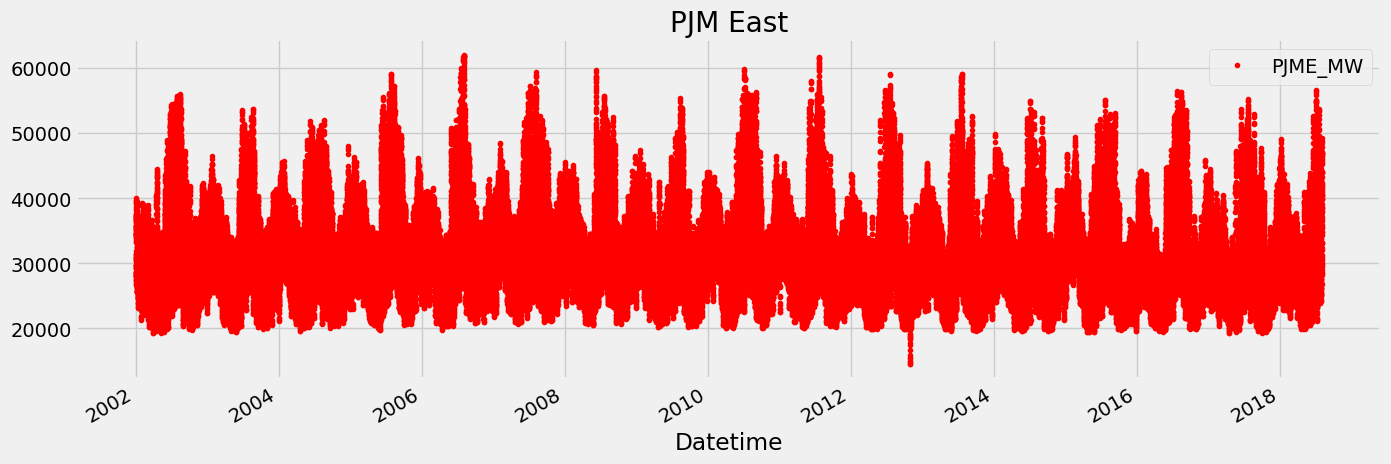

In [10]:
pjme.plot(style = '.' , color = "red", figsize = (15,5), title = "PJM East");

## EDA

Let's create time series features from datetime index

In [11]:
pjme['date'] = pjme.index
pjme['hour'] = pjme['date'].dt.hour
pjme['dayofweek'] = pjme['date'].dt.dayofweek
pjme['quarter'] = pjme['date'].dt.quarter
pjme['month'] = pjme['date'].dt.month
pjme['year'] = pjme['date'].dt.year
pjme['dayofyear'] = pjme['date'].dt.dayofyear
pjme['dayofmonth'] = pjme['date'].dt.day
pjme['weekofyear'] = pjme['date'].dt.strftime('%U')
pjme.drop(['date'], axis = 1, inplace=True)

In [12]:
pjme.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,52
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,52
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,52
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,52
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,52


In [13]:
pjme.isna().sum(axis = 0)

PJME_MW       0
hour          0
dayofweek     0
quarter       0
month         0
year          0
dayofyear     0
dayofmonth    0
weekofyear    0
dtype: int64

<Axes: xlabel='hour', ylabel='PJME_MW'>

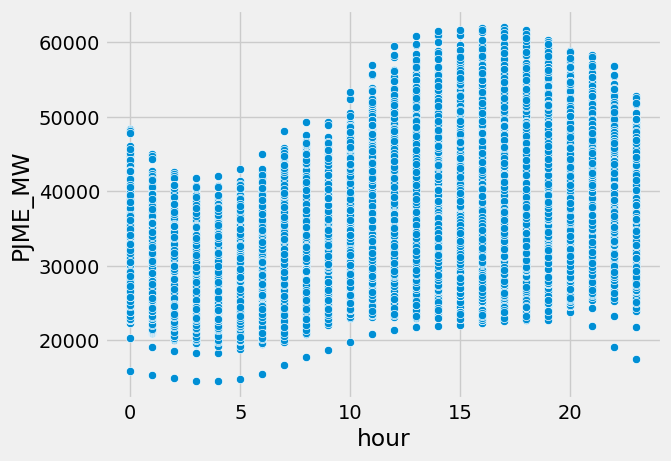

In [14]:
sns.scatterplot(x=pjme['hour'], y=pjme['PJME_MW'])

<Axes: xlabel='dayofweek', ylabel='PJME_MW'>

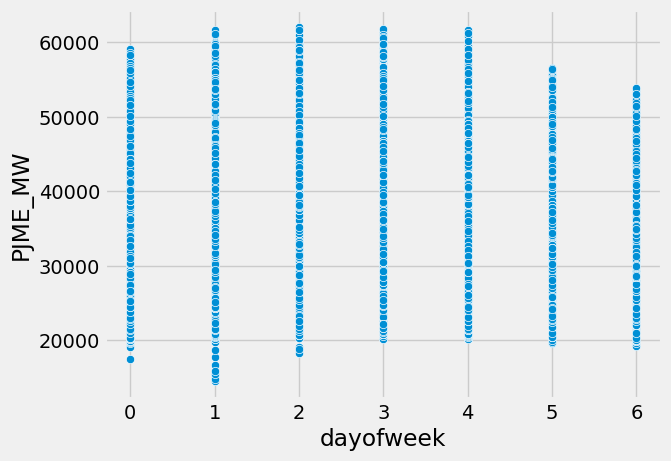

In [15]:
sns.scatterplot(x=pjme['dayofweek'], y=pjme['PJME_MW'] )

<Axes: xlabel='month', ylabel='PJME_MW'>

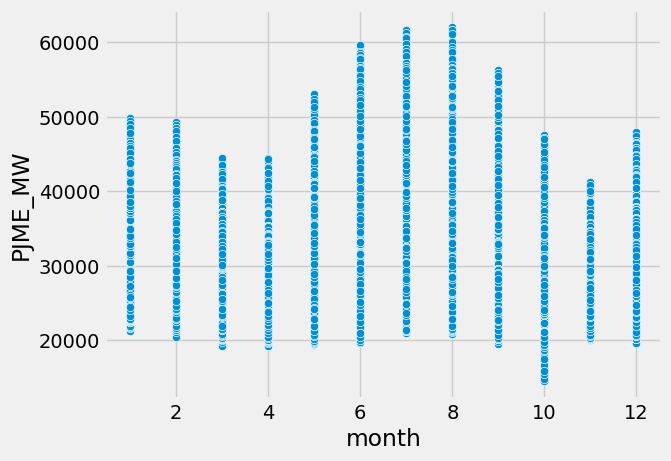

In [16]:
sns.scatterplot(x=pjme['month'], y=pjme['PJME_MW'])

(array([2000., 2002., 2004., 2006., 2008., 2010., 2012., 2014., 2016.,
        2018., 2020.]),
 [Text(2000.0, 0, '2000'),
  Text(2002.0, 0, '2002'),
  Text(2004.0, 0, '2004'),
  Text(2006.0, 0, '2006'),
  Text(2008.0, 0, '2008'),
  Text(2010.0, 0, '2010'),
  Text(2012.0, 0, '2012'),
  Text(2014.0, 0, '2014'),
  Text(2016.0, 0, '2016'),
  Text(2018.0, 0, '2018'),
  Text(2020.0, 0, '2020')])

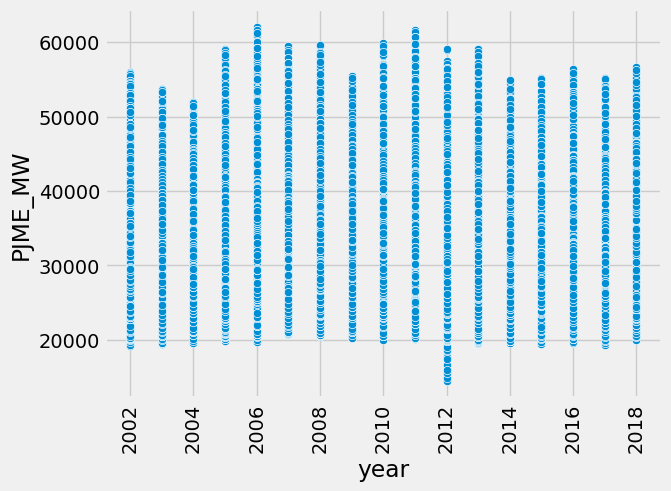

In [17]:
sns.scatterplot(x=pjme['year'], y=pjme['PJME_MW'])
plt.xticks(rotation = 'vertical')

<Axes: xlabel='weekofyear', ylabel='PJME_MW'>

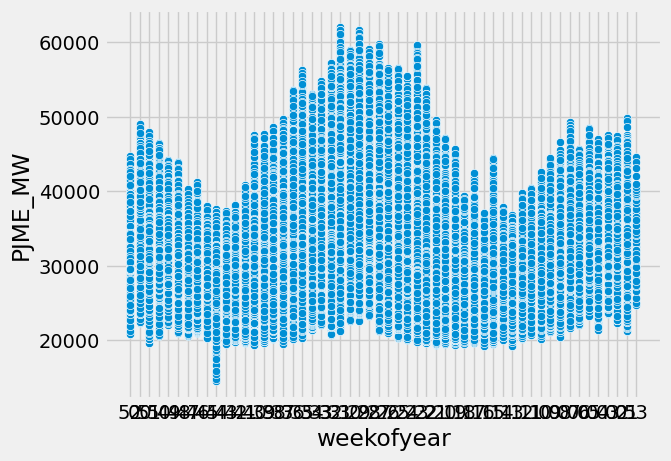

In [18]:
sns.scatterplot(x=pjme['weekofyear'], y=pjme['PJME_MW'])

## Train-Test Split

Cut off the data after 2015 to use as our validation set.

In [19]:
pjme_train = pjme.loc[pjme.year < 2015]
pjme_test = pjme.loc[pjme.year >= 2015]

In [20]:
pjme_train.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2014-01-01 20:00:00,36193.0,20,2,1,1,2014,1,1,00
2014-01-01 21:00:00,35601.0,21,2,1,1,2014,1,1,00
2014-01-01 22:00:00,34242.0,22,2,1,1,2014,1,1,00
2014-01-01 23:00:00,32215.0,23,2,1,1,2014,1,1,00
2014-01-02 00:00:00,30159.0,0,3,1,1,2014,2,2,00


In [21]:
pjme_test.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,1,00
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,31,52
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,31,52
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,31,52
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,31,52


In [ ]:
#(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'})).append(pjme_test.rename(columns={'PJME_MW': 'TEST SET'}), sort = False)[['TRAINING SET','TEST SET']].plot(style='.', figsize = (15,5), title = "PJM East");

In [31]:
x_train = pjme_train[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']].to_numpy()
x_test = pjme_test[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']].to_numpy()
y_train = pjme_train[['PJME_MW']].to_numpy()
y_test = pjme_test[['PJME_MW']].to_numpy()

In [32]:
y_train

array([[26498.],
       [25147.],
       [24574.],
       ...,
       [34242.],
       [32215.],
       [30159.]])

## XG Boost Model

In [24]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [34]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(x_train, y_train,
       eval_set = [(x_train, y_train), (x_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

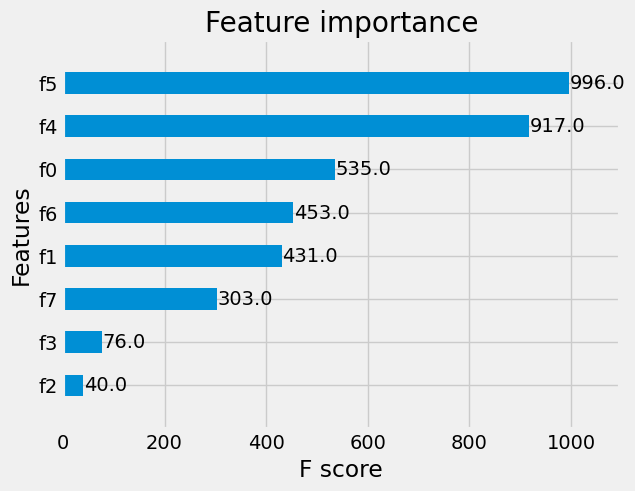

In [35]:
plot_importance(reg, height = 0.5)

In [36]:
pjme_test['MW_Prediction'] = reg.predict(x_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

<ipython-input-36-718a3d9e5890>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pjme_test['MW_Prediction'] = reg.predict(x_test)


<Axes: xlabel='Datetime'>

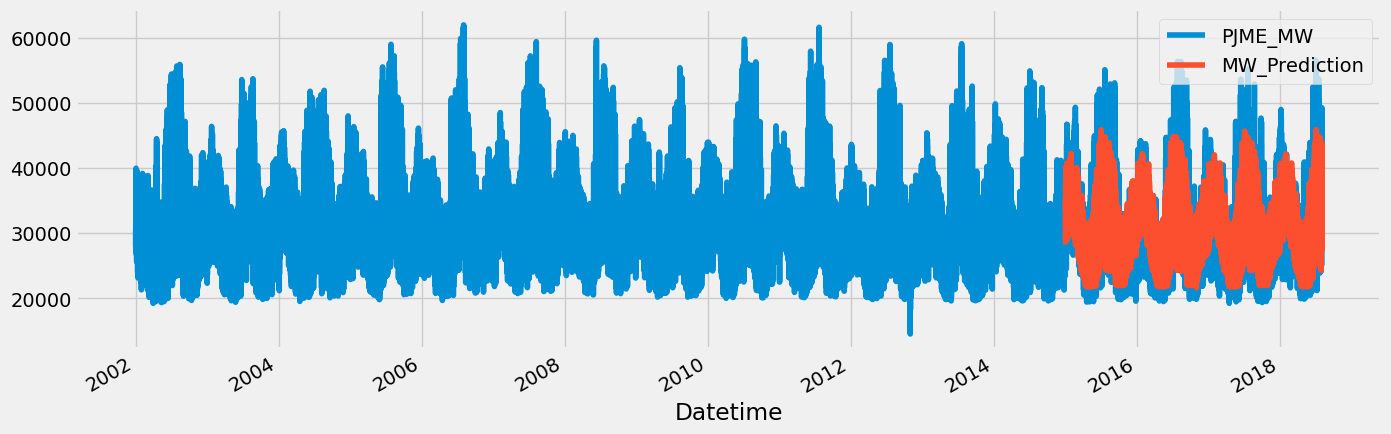

In [37]:
pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

#### First Month of Prediction

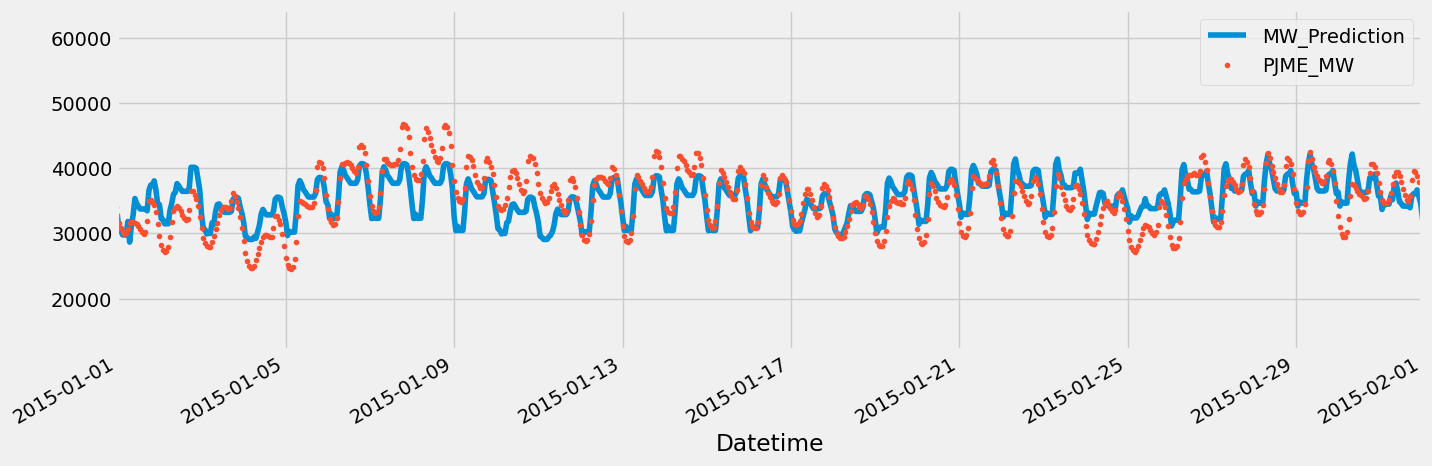

In [38]:
_, ax = plt.subplots(1)
pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'],figsize=(15, 5))
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')

#### First week of January

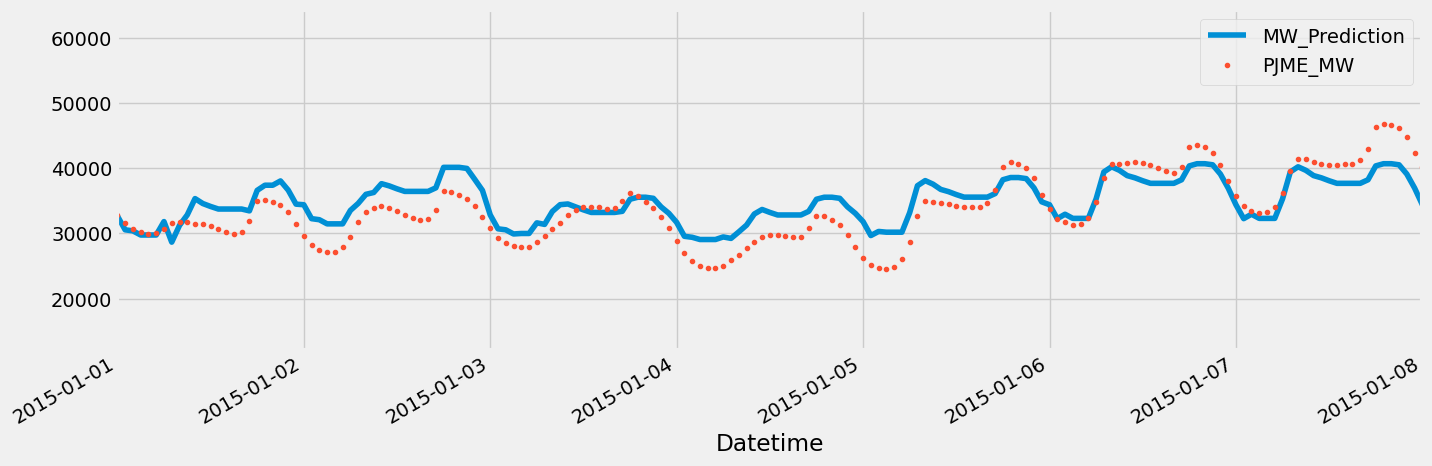

In [39]:
_, ax = plt.subplots(1)
pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'],figsize=(15, 5))
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')

#### First Week of July

In [ ]:
_, ax = plt.subplots(1)
pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'],figsize=(15, 5))
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')

#### Error Metrics

In [40]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

14108116.76188746

In [41]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

2923.642744115776

In [42]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

9.302493762246362

#### Analysis of worst and best predicted days

In [43]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)

<ipython-input-43-ef8a95843d13>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
<ipython-input-43-ef8a95843d13>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)


In [44]:
error_by_day = pjme_test.groupby(['year','month','dayofmonth']).mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [45]:
error_by_day.head(10)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2015 1     1           31765.583333   33364.566406 -1598.981689  2095.252360
           2           32141.166667   35987.648438 -3846.481201  3846.481201
           3           32014.375000   33014.792969 -1000.415365  1503.045898
           4           28542.291667   32155.591797 -3613.299235  3613.299235
           5           33176.125000   35079.355469 -1903.229736  2846.579346
           6           38358.833333   37261.644531  1097.190267  1539.549316
           7           40181.875000   37261.644531  2920.231934  2920.231934
           8           42445.375000   37261.644531  5183.731934  5183.731934
           9           38524.666667   35188.292969  3336.373128  3336.373128
           10          37703.583333   33034.875000  4668.707113  4668.707113

##### Over feorecasted days

In [46]:
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2016 7     4           28399.958333   37400.683594 -9000.722982  9000.722982
2018 1     28          27356.541667   35077.507812 -7720.965983  7720.965983
2015 12    25          24466.083333   32138.218750 -7672.134277  7672.134277
2017 9     2           24201.458333   31735.767578 -7534.309814  7534.309814
     2     28          28297.875000   35815.289062 -7517.414388  7517.414388
           24          26445.083333   33941.773438 -7496.690837  7496.690837
           19          24555.500000   32007.757812 -7452.257161  7452.257161
2018 1     23          29773.833333   37212.320312 -7438.486165  7438.486165
2017 5     29          24528.416667   31658.685547 -7130.269043  7130.269043
2018 2     28          28915.166667   36006.925781 -7091.759847  7091.759847

We can see,
1st worst day: 4th July,2016 - Holiday
3rd worst day: 25th December,2015 - Christmas
5th worst day: 4th July,2016 - Holiday

We should consider holidays in our analysis.

##### Worst Absolute Predicted days

In [ ]:
error_by_day.sort_values('abs_error', ascending=False).head(10)

##### Best Absolute Predicted days

In [ ]:
error_by_day.sort_values('abs_error', ascending=True).head(10)

The best predicted days seem to be a lot of october (not many holidays and mild weather) Also early may.

#### Plotting Best/Worst predicted Days

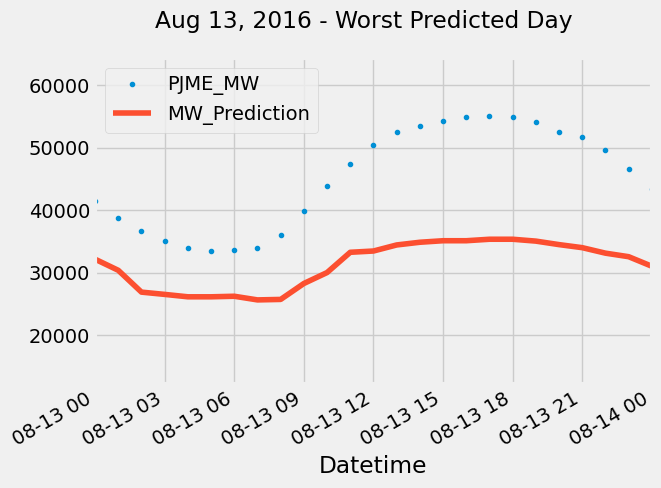

In [47]:
_, ax = plt.subplots(1)
pjme_all[['PJME_MW','MW_Prediction']].plot(ax=ax, style=['.','-'])
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

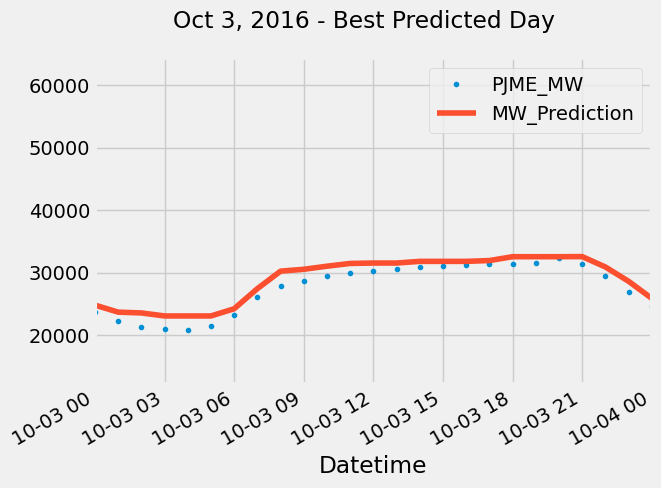

In [48]:
_, ax = plt.subplots(1)
pjme_all[['PJME_MW','MW_Prediction']].plot(ax=ax, style=['.','-'])
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

## Linear model

In [49]:
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, Lasso, HuberRegressor
reg=LinearRegression(fit_intercept=False)
reg.fit(x_train, y_train)

LinearRegression(fit_intercept=False)

In [50]:
reg.coef_

array([[  462.33645337,  -648.38588773,  -251.48756055, -9312.17181331,
           19.43905638,   436.26462148,  -303.8780242 ,  -911.70565396]])

In [51]:
y_pred=reg.predict(x_test)
pjme_test['MW_Prediction_lin'] = reg.predict(x_test)
from sklearn.metrics import r2_score
rez=r2_score(y_test, y_pred)
print(rez)
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction_lin'])

0.21554211924919386


<ipython-input-51-9645a8731533>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pjme_test['MW_Prediction_lin'] = reg.predict(x_test)


15.339434523545684

In [52]:
from sklearn.neighbors import KNeighborsRegressor
#https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-regression
reg = KNeighborsRegressor(n_neighbors=4)
reg.fit(x_train, y_train)
y_pred=reg.predict(x_test)
pjme_test['MW_Prediction_knn'] = reg.predict(x_test)
from sklearn.metrics import r2_score
rez=r2_score(y_test, y_pred)
print(rez)
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction_knn'])

0.43186905804227016


<ipython-input-52-479a324c830b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pjme_test['MW_Prediction_knn'] = reg.predict(x_test)


11.546390615842466

In [53]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(max_depth=50, random_state=0)
reg.fit(x_train, y_train)
y_pred=reg.predict(x_test)
pjme_test['MW_Prediction_rfr'] = reg.predict(x_test)
from sklearn.metrics import r2_score
rez=r2_score(y_test, y_pred)
print(rez)
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction_rfr'])

<ipython-input-53-20812fefef2b>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(x_train, y_train)


0.558833693673255


<ipython-input-53-20812fefef2b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pjme_test['MW_Prediction_rfr'] = reg.predict(x_test)


9.791947078237813

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor


# Training Regressors
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(max_depth=50, random_state=1)
reg3 = KNeighborsRegressor(n_neighbors=3)
reg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
reg = reg.fit(x_train, y_train)
y_pred=reg.predict(x_test)
pjme_test['MW_Prediction_Grad'] = reg.predict(x_test)
from sklearn.metrics import r2_score
rez=r2_score(y_test, y_pred)
print(rez)
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction_Grad'])

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
_, ax = plt.subplots(1)
pjme_test[['MW_Prediction', 'MW_Prediction_lin','MW_Prediction_knn','MW_Prediction_rfr','MW_Prediction_Grad','PJME_MW']].plot(ax=ax, style=['-','-','-','-','-','.'],figsize=(25, 15))
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')

In [ ]:
x_train